# Want your song to be part of Billboard Year-End Hot 100 singles?<br>ask Data Sciense.

In [151]:
import pandas as pd
from pandas import DataFrame, read_csv
import scipy as sc
import numpy as np
import seaborn as sns

import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

from sklearn import metrics,tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

### Take the dataframe with all the information we collected and change him to dataframe with data that we can work good with Decision Tree algorith.

In [35]:
df_spotify=pd.read_csv("./data/spotify_after.csv")

In [36]:
df_spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 37 columns):
Title                         512 non-null object
Artist                        512 non-null object
id                            512 non-null object
artist_genres                 512 non-null object
is_single                     512 non-null int64
total_tracks                  512 non-null int64
release_date                  512 non-null object
day_of_week                   512 non-null int64
release_season                512 non-null int64
Year                          512 non-null int64
is_top100                     512 non-null int64
acousticness                  512 non-null float64
danceability                  512 non-null float64
duration_ms                   512 non-null int64
energy                        512 non-null float64
instrumentalness              512 non-null float64
key                           512 non-null int64
liveness                      512 non-null float6

### Change the song duration from ms to minutes

In [37]:
print(df_spotify['duration_ms'].head(10))
df_spotify['duration_ms'] = round(df_spotify['duration_ms'] / 60000 , 2)
df_spotify.rename(columns={"duration_ms": "duration_min"}, inplace=True)
print(df_spotify['duration_min'].head(10))

0    233720
1    200787
2    173987
3    219320
4    202333
5    246761
6    295493
7    208373
8    236002
9    244960
Name: duration_ms, dtype: int64
0    3.90
1    3.35
2    2.90
3    3.66
4    3.37
5    4.11
6    4.92
7    3.47
8    3.93
9    4.08
Name: duration_min, dtype: float64


In [38]:
lst=df_spotify['artist_genres'].values

genres=[]
j=0
for i in lst:
    ls=i.split(',')
    if len(ls)>1:
        genres.append(ls[1].replace(" '","").replace("]","").replace("[","").replace("'",""))
    else:
        genres.append(ls[0].replace(" '","").replace("]","").replace("[","").replace("'",""))
    if genres[j]=='':
        genres[j]=pd.np.NaN
    j+=1

In [41]:
df_spotify['Genres']=genres
df_spotify['Genres'].tail()

507    post-teen pop
508        dance pop
509              rap
510        viral pop
511          pop rap
Name: Genres, dtype: object

### Give each genre his own column and mark in true/false according to the song.

In [92]:
set_temp = df_spotify['Genres']
set_temp = set(set_temp)
print(len(set_temp))
print(set_temp)

80
{' "childrens music"', 'girl group', 'san diego rap', 'melodic rap', 'latin hip hop', 'australian electropop', 'philly rap', 'basshall', 'dance pop', 'hollywood', 'country', 'hip hop', 'complextro', 'viral trap', 'chicago rap', 'miami hip hop', 'pop rock', 'atl hip hop', 'neo-singer-songwriter', 'pittsburgh rap', 'lgbtq+ hip hop', 'edm', 'uk pop', 'french indie pop', 'latin', 'new americana', 'trap', 'tropical house', 'atl trap', 'electro house', 'icelandic rock', 'canadian indie', 'southern hip hop', 'gangster rap', 'australian reggae fusion', 'dmv rap', 'latin pop', 'r&b', 'minnesota hip hop', 'electropop', 'west coast trap', 'escape room', 'israeli pop', 'acoustic pop', 'reggaeton', 'jewish pop', 'australian pop', 'viral pop', 'new orleans rap', 'funk metal', 'pop', 'la pop', 'dirty south rap', 'canadian pop', 'post-teen pop', 'christian alternative rock', 'hip pop', 'chamber pop', 'video game music', 'indie rock', 'country road', 'country pop', 'gaming edm', 'russian hip hop', '

In [96]:
set_genres = set()

for i in set_temp:
    i = i.replace('"', '').lstrip().lstrip().replace(' ','-')
    i = 'is_' + i
    set_genres.add(i)

print(len(set_genres))
print(set_genres)

80
{'is_childrens-music', 'is_tropical-house', 'is_san-diego-rap', 'is_east-coast-hip-hop', 'is_indie-rock', 'is_chamber-pop', 'is_idol', 'is_pop-rap', 'is_latin', 'is_new-americana', 'is_canadian-pop', 'is_australian-pop', 'is_electro-house', 'is_canadian-singer-songwriter', 'is_indie-poptimism', 'is_neo-singer-songwriter', 'is_icelandic-rock', 'is_west-coast-trap', 'is_house', 'is_israeli-pop', 'is_escape-room', 'is_canadian-indie', 'is_atl-hip-hop', 'is_contemporary-country', 'is_minnesota-hip-hop', 'is_dmv-rap', 'is_girl-group', 'is_latin-hip-hop', 'is_electropop', 'is_emo', 'is_edm', 'is_latin-pop', 'is_modern-rock', 'is_swedish-gangsta-rap', 'is_country', 'is_chicago-rap', 'is_atl-trap', 'is_miami-hip-hop', 'is_philly-rap', 'is_viral-pop', 'is_g-funk', 'is_pinoy-hip-hop', 'is_post-teen-pop', 'is_hip-hop', 'is_country-road', 'is_rock', 'is_jewish-pop', 'is_melodic-rap', 'is_dance-pop', 'is_viral-trap', 'is_basshall', 'is_pittsburgh-rap', 'is_indie-soul', 'is_gangster-rap', 'is_aco

In [122]:
print(df_spotify.shape)
for i in set_genres:
    df_spotify['{}'.format(i)] = 0
print(df_spotify.shape)

(507, 118)
(507, 118)


In [123]:
for i, row in df_spotify.iterrows():
    cur_genre = row['Genres']
    cur_genre = cur_genre.replace('"', '').lstrip().lstrip().replace(' ','-')
    cur_genre = 'is_' + cur_genre
    df_spotify.set_value(i, cur_genre, 1)
df_spotify['is_pop'].head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


0    1
1    1
2    0
3    0
4    0
Name: is_pop, dtype: int64

In [124]:
df_spotify=df_spotify.dropna()
len(df_spotify)

507

In [125]:
df_spotify.groupby(['Genres']).mean()

,is_single,total_tracks,day_of_week,release_season,Year,is_top100,acousticness,danceability,duration_min,energy,...,is_hip-pop,is_uk-pop,is_lgbtq+-hip-hop,is_french-indie-pop,is_russian-hip-hop,is_rap,is_country-pop,is_funk-metal,is_la-pop,is_gaming-edm
Genres,,,,,,,,,,,,,,,,,,,,,
"""childrens music""",1.000000,20.000000,4.000000,2.000000,2017.000000,0.000000,0.259000,0.829000,1.350000,0.886000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acoustic pop,0.000000,1.000000,5.000000,4.000000,2017.000000,0.000000,0.469000,0.618000,3.310000,0.443000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
atl hip hop,1.000000,14.000000,5.000000,3.000000,2016.000000,0.000000,0.030700,0.417000,4.110000,0.580000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
atl trap,0.800000,11.800000,4.800000,2.000000,2017.200000,0.400000,0.073344,0.832000,3.308000,0.599400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
australian electropop,1.000000,16.000000,5.000000,1.000000,2016.000000,1.000000,0.441000,0.443000,3.890000,0.558000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
australian pop,1.000000,13.600000,5.000000,3.800000,2016.000000,0.400000,0.089160,0.590600,3.624000,0.764000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
australian reggae fusion,1.000000,6.000000,3.000000,1.000000,2017.000000,0.000000,0.285000,0.589000,5.260000,0.699000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
basshall,1.000000,13.000000,5.000000,3.000000,2018.000000,0.000000,0.061700,0.829000,2.850000,0.797000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
canadian indie,1.000000,11.000000,5.000000,1.000000,2016.000000,0.000000,0.163000,0.556000,3.390000,0.658000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
df_spotify.sort_values(by='words_curse_count')

,Title,Artist,id,artist_genres,is_single,total_tracks,release_date,day_of_week,release_season,Year,...,is_hip-pop,is_uk-pop,is_lgbtq+-hip-hop,is_french-indie-pop,is_russian-hip-hop,is_rap,is_country-pop,is_funk-metal,is_la-pop,is_gaming-edm
0,Love Yourself,Justin Bieber,3hB5DgAiMAQ4DzYbsMq1IT,"['canadian pop', 'pop', 'post-teen pop']",1,19,2015-11-13,5,3,2015,...,0,0,0,0,0,0,0,0,0,0
310,Ophelia,The Lumineers,5NORWMFC27ywGSZxi8uquP,"['folk-pop', 'modern rock', 'stomp and holler']",1,11,2016-04-08,5,1,2016,...,0,0,0,0,0,0,0,0,0,0
308,Can I Be Him,James Arthur,5ZMCXFJe9EyL9TM6PrA56U,"['pop', 'post-teen pop', 'talent show', 'uk pop']",1,18,2016-10-28,5,3,2016,...,0,0,0,0,0,0,0,0,0,0
304,Alone,Marshmello,3MEYFivt6bilQ9q9mFWZ4g,"['brostep', 'pop', 'progressive electro house']",0,1,2016-05-13,5,1,2016,...,0,0,0,0,0,0,0,0,0,0
301,Nevermind,Dennis Lloyd,3PHjgrovCBjQQl5Np5YQBy,['israeli pop'],0,1,2016-09-18,7,3,2016,...,0,0,0,0,0,0,0,0,0,0
300,Fight Song,Rachel Platten,37f4ITSlgPX81ad2EvmVQr,"['pop', 'post-teen pop', 'viral pop']",1,12,2016-01-01,5,4,2016,...,0,0,0,0,0,0,0,0,0,0
299,The Greatest,Sia,7xHWNBFm6ObGEQPaUxHuKO,"['australian dance', 'australian pop', 'dance ...",1,19,2016-10-21,5,3,2016,...,0,0,0,0,0,0,0,0,0,0
298,Million Reasons,Lady Gaga,7dZ1Odmx9jWIweQSatnRqo,"['dance pop', 'pop', 'post-teen pop']",1,14,2016-10-21,5,3,2016,...,0,0,0,0,0,0,0,0,0,0
311,How Far Ill Go,Aulii Cravalho,6mb6lVLNrcUgLnEN8QnDJd,"['disney', 'hollywood', 'movie tunes', 'show t...",1,59,2016-11-18,5,3,2016,...,0,0,0,0,0,0,0,0,0,0
297,Six Feet Under,Billie Eilish,2VlLbhGLVJgdOW7kKdWWFc,"['electropop', 'pop']",0,1,2016-11-17,4,3,2016,...,0,0,0,0,0,0,0,0,0,0


In [127]:
top100 = df_spotify[df_spotify['is_top100'] == 1]
not_top100 = df_spotify[df_spotify['is_top100'] == 0]

In [128]:
top100.describe()

,is_single,total_tracks,day_of_week,release_season,Year,is_top100,acousticness,danceability,duration_min,energy,...,is_hip-pop,is_uk-pop,is_lgbtq+-hip-hop,is_french-indie-pop,is_russian-hip-hop,is_rap,is_country-pop,is_funk-metal,is_la-pop,is_gaming-edm
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.0,288.000000,288.000000,288.000000,288.000000,...,288.000000,288.000000,288.0,288.0,288.0,288.000000,288.000000,288.0,288.0,288.0
mean,0.673611,10.774306,4.559028,2.326389,2016.645833,1.0,0.166151,0.696247,3.665937,0.630561,...,0.010417,0.013889,0.0,0.0,0.0,0.041667,0.003472,0.0,0.0,0.0
std,0.469708,7.367016,1.037614,1.137452,0.973293,0.0,0.192014,0.134976,0.602843,0.146973,...,0.101706,0.117234,0.0,0.0,0.0,0.200174,0.058926,0.0,0.0,0.0
min,0.000000,1.000000,1.000000,1.000000,2015.000000,1.0,0.000243,0.333000,2.030000,0.056500,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
25%,0.000000,1.000000,5.000000,1.000000,2016.000000,1.0,0.029025,0.611750,3.337500,0.533750,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
50%,1.000000,13.000000,5.000000,2.000000,2017.000000,1.0,0.087800,0.700500,3.620000,0.640500,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
75%,1.000000,16.000000,5.000000,3.000000,2017.000000,1.0,0.222750,0.791750,3.930000,0.743000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
max,1.000000,28.000000,7.000000,4.000000,2018.000000,1.0,0.965000,0.964000,6.970000,0.928000,...,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0


In [129]:
not_top100.describe()

,is_single,total_tracks,day_of_week,release_season,Year,is_top100,acousticness,danceability,duration_min,energy,...,is_hip-pop,is_uk-pop,is_lgbtq+-hip-hop,is_french-indie-pop,is_russian-hip-hop,is_rap,is_country-pop,is_funk-metal,is_la-pop,is_gaming-edm
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.0,219.000000,219.000000,219.000000,219.000000,...,219.0,219.000000,219.000000,219.000000,219.000000,219.000000,219.0,219.000000,219.000000,219.000000
mean,0.639269,10.054795,4.794521,2.456621,2016.986301,0.0,0.291632,0.648096,3.472420,0.598646,...,0.0,0.013699,0.022831,0.004566,0.004566,0.054795,0.0,0.004566,0.004566,0.004566
std,0.481313,7.610755,0.908051,1.032361,0.848525,0.0,0.271774,0.136638,0.878194,0.179440,...,0.0,0.116503,0.149707,0.067574,0.067574,0.228100,0.0,0.067574,0.067574,0.067574
min,0.000000,1.000000,1.000000,1.000000,2016.000000,0.0,0.000450,0.278000,1.350000,0.048500,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.000000,1.000000,5.000000,2.000000,2016.000000,0.0,0.067100,0.560000,3.015000,0.496000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,1.000000,11.000000,5.000000,2.000000,2017.000000,0.0,0.194000,0.667000,3.360000,0.609000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,1.000000,15.000000,5.000000,3.000000,2018.000000,0.0,0.463500,0.746000,3.695000,0.728000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,1.000000,59.000000,7.000000,4.000000,2018.000000,0.0,0.947000,0.935000,9.960000,0.953000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


In [130]:
top100_by_year=top100.groupby(['Year'])

In [131]:
top100_by_year=top100_by_year[['duration_min','words_count', 'stopwords_count', 'words_neg_count', 'words_pos_count', 'words_curse_count', 'words_repeat_count']].mean()
top100_by_year

,duration_min,words_count,stopwords_count,words_neg_count,words_pos_count,words_curse_count,words_repeat_count
Year,,,,,,,
2015,3.737949,1843.538462,131.615385,550.769231,437.179487,2.948718,172.025641
2016,3.751818,2110.431818,139.375000,561.000000,471.022727,5.204545,202.272727
2017,3.631649,2134.082474,150.515464,475.298969,453.865979,7.103093,201.628866
2018,3.555938,2365.078125,152.531250,469.500000,414.453125,7.437500,229.671875


[]

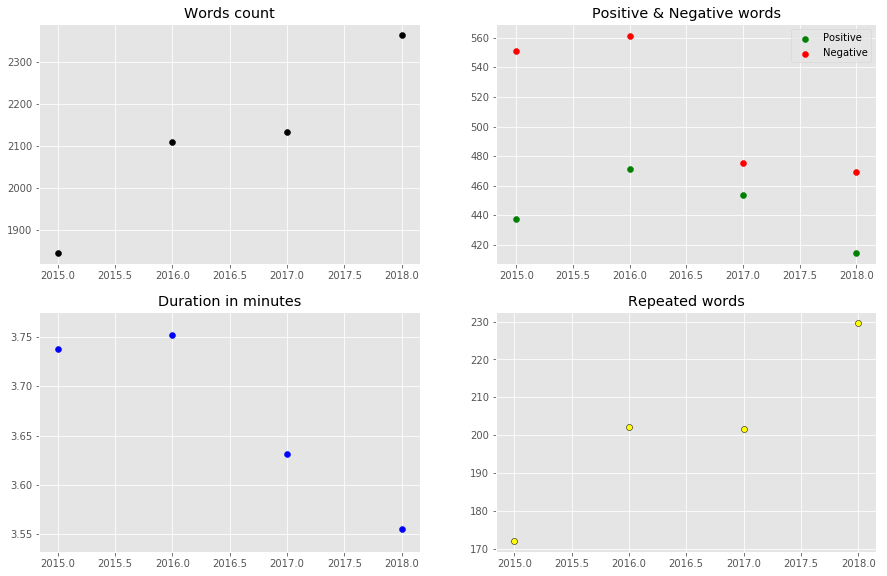

In [132]:
plt.figure(figsize=(15, 15))

plt.subplot(321)
plt.title('Words count')
plt.scatter(top100_by_year.index, top100_by_year['words_count'] ,color='black', label="data", linewidths=0.5, edgecolors='black');
plt.plot()


plt.subplot(322)

plt.title('Positive & Negative words')
plt.scatter(top100_by_year.index, top100_by_year['words_pos_count'] ,color='green', label="data");
plt.scatter(top100_by_year.index, top100_by_year['words_neg_count'] ,color='red', label="data");
plt.legend(('Positive', 'Negative'))
plt.plot()

plt.subplot(323)

plt.title('Duration in minutes')
plt.scatter(top100_by_year.index, top100_by_year['duration_min'] ,color='blue', label="data");
plt.plot()

plt.subplot(324)
plt.title('Repeated words')
plt.scatter(top100_by_year.index, top100_by_year['words_repeat_count'] ,color='yellow', label="data", linewidths=0.5, edgecolors='black');
plt.plot()

In [133]:
df_spotify_by_year=df_spotify.groupby(['release_season'])

In [134]:
df_spotify_by_year=df_spotify_by_year[['is_top100']].mean()
df_spotify_by_year

,is_top100
release_season,
1,0.654676
2,0.539568
3,0.472000
4,0.605769


[]

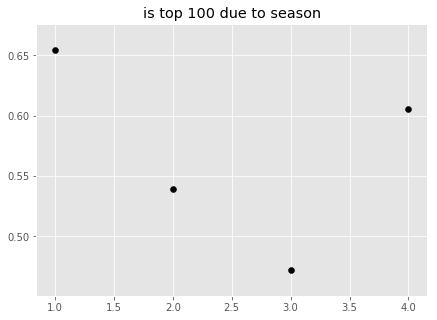

In [135]:
plt.figure(figsize=(7, 5))


plt.title('is top 100 due to season')
plt.scatter(df_spotify_by_year.index,df_spotify_by_year['is_top100'] ,color='black', label="data", linewidths=0.5, edgecolors='black');
plt.plot()

array([ 0.87201873,  0.87201873,  0.87201873,  0.87201873,  0.87201873,
        0.87201873,  0.87201873,  0.87201873,  0.87201873,  0.87201873,
        0.87201873,  0.87201873,  0.87201873,  0.87201873,  0.87201873,
        0.87201873,  0.87201873,  0.87201873,  0.87201873,  0.87201873,
        0.87201873,  0.87201873,  0.87201873,  0.87201873,  0.87201873,
        0.87201873,  0.87201873,  0.87201873,  0.87201873,  0.87201873,
        0.87201873,  0.87201873,  0.87201873,  0.87201873,  0.87201873,
        0.87201873,  0.87201873,  0.87201873,  0.87201873,  0.87201873,
        0.87201873,  0.87201873,  0.87201873,  0.87201873,  0.87201873,
        0.87201873,  0.87201873,  0.87201873,  0.87201873,  0.87201873,
        0.87201873,  0.87201873,  0.87201873,  0.87201873,  0.87201873,
        0.87201873,  0.87201873,  0.87201873,  0.87201873,  0.87201873,
        0.87201873,  0.87201873,  0.87201873,  0.87201873,  0.87201873,
        0.87201873,  0.87201873,  0.87201873,  0.87201873,  0.87

In [140]:
df_spotify.info(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 0 to 511
Data columns (total 118 columns):
Title                            object
Artist                           object
id                               object
artist_genres                    object
is_single                        int64
total_tracks                     int64
release_date                     object
day_of_week                      int64
release_season                   int64
Year                             int64
is_top100                        int64
acousticness                     float64
danceability                     float64
duration_min                     float64
energy                           float64
instrumentalness                 float64
key                              int64
liveness                         float64
loudness                         float64
mode                             int64
speechiness                      float64
tempo                            float64
time_signatur

In [141]:
print(df_spotify.shape)
df_spotify = df_spotify.drop(['Title', 'Artist', 'id', 'artist_genres', 'release_date', 'Year', 'Genres'], 1)
print(df_spotify.shape)

(507, 118)
(507, 111)


In [142]:
y = df_spotify['is_top100'].values.tolist()
type(y)

list

In [144]:
XTrain, XTest, yTrain, yTest = train_test_split(df_spotify, y, test_size=0.2)

In [154]:
clf = tree.DecisionTreeClassifier()
clf.fit(XTrain, yTrain)

y_pred = clf.predict(XTest)
y_pred_train = clf.predict(XTrain)

print('Accuracy on Train data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
print(confusion_matrix(yTest, y_pred))

print(classification_report(yTest,y_pred))

# clf = tree.DecisionTreeClassifier()
# parameters = {'max_depth':(3,5,10), 'min_samples_split':[10, 15,20]}
# clfCV = GridSearchCV(clf, parameters, cv=10)
# clfCV.fit(X.reshape(-1,1), y)

# am=np.argmax(clfCV.cv_results_["mean_test_score"])
# print("DT")
# print("best value {} for permutation {}".format(clfCV.cv_results_["mean_test_score"][am],clfCV.cv_results_["params"][am]))

Accuracy on Train data=  1.0
Accuracy on test data=  1.0
[[42  0]
 [ 0 60]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00        60

   micro avg       1.00      1.00      1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102

